<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feat%2Fexperiment-4/experiments/experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Prepare Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! ls
%cd drive/MyDrive/MachineLearning/Geospatial_ML
#! ls
! git pull
! git checkout feat/experiment-4

drive  sample_data
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10 (delta 5), reused 6 (delta 5), pack-reused 0
Unpacking objects: 100% (10/10), 8.45 KiB | 7.00 KiB/s, done.
From https://github.com/emely3h/Geospatial_ML
   195b13b..b7633ab  feat/experiment-4 -> origin/feat/experiment-4
   9bb8967..9ad1077  main              -> origin/main
Updating 195b13b..b7633ab
Fast-forward
 evaluation/chunk_jaccard_matrix.py     | 66 ++++++++++++++++++++--------------
 evaluation/evaluation_metrics_total.py | 40 +++++++++++----------
 evaluation/helpers.py                  | 35 +++++++++++-------
 3 files changed, 84 insertions(+), 57 deletions(-)
Already on 'feat/experiment-4'
Your branch is up to date with 'origin/feat/experiment-4'.


In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)
from keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pickle
from keras.utils import Sequence
from datetime import datetime
from models.unet_model import unet_2d
from data_exploration.mask_stats import Mask_Stats

In [6]:
total_tiles = 11121
train_tiles = 6672
test_val_tiles = 2224
data_path = "../data_colab/256_256"

### 1. Create Data Generators

In [7]:


train_split_x = np.memmap(os.path.join(data_path, "train_split_x.npy"), mode="r", shape=(train_tiles, 256, 256, 5), dtype=np.uint8)
train_split_y = np.memmap(os.path.join(data_path, "train_split_y.npy"), mode="r", shape=(train_tiles, 256, 256), dtype=np.uint8)
val_split_x = np.memmap(os.path.join(data_path, "val_split_x.npy"), mode="r", shape=(test_val_tiles, 256, 256, 5), dtype=np.uint8)
val_split_y = np.memmap(os.path.join(data_path, "val_split_y.npy"), mode="r", shape=(test_val_tiles, 256, 256), dtype=np.uint8)
test_split_x = np.memmap(os.path.join(data_path, "test_split_x.npy"), mode="r", shape=(test_val_tiles, 256, 256, 5), dtype=np.uint8)
test_split_y = np.memmap(os.path.join(data_path, "test_split_y.npy"), mode="r", shape=(test_val_tiles, 256, 256), dtype=np.uint8)

train_stats = Mask_Stats(train_split_y)
train_stats.print_stats()
print()
val_stats = Mask_Stats(val_split_y)
val_stats.print_stats()
print()
test_stats = Mask_Stats(test_split_y)
test_stats.print_stats()

Shape: (6672, 256, 256)
Land pixels: 195058814  44.610 %
Valid pixels: 138904480  31.767 %
Invalid pixels: 103292898  23.623 %
Sum: 6672

Shape: (2224, 256, 256)
Land pixels: 65320265  44.816 %
Valid pixels: 46246663  31.730 %
Invalid pixels: 34185136  23.454 %
Sum: 2224

Shape: (2224, 256, 256)
Land pixels: 64786699  44.450 %
Valid pixels: 46892391  32.173 %
Invalid pixels: 34072974  23.377 %
Sum: 2224


In [8]:
class DataGenerator(Sequence):
    def __init__(self, mmap_x, mmap_y, batch_size):
        self.x_input = mmap_x
        self.y_mask = mmap_y
        self.batch_size = batch_size
        self.num_samples = self.x_input.shape[0]

    # returns number of batches as int    
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    # returns single batch
    def __getitem__(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.x_input[batch_indices]
        batch_masks = self.y_mask[batch_indices]

        # normalization
        batch_inputs = batch_inputs/255
        # one-hot-encoding
        batch_masks = np.array([tf.one_hot(item, depth=3).numpy() for item in batch_masks])      
        
        # normalization + one hot encoding
        return batch_inputs, batch_masks
    
    def getitem_as_img(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.x_input[batch_indices]
        batch_masks = self.y_mask[batch_indices]
        # normalization + one hot encoding
        return batch_inputs, batch_masks

In [9]:
# instanciate DataGenerators
batch_size = 32

train_generator = DataGenerator(train_split_x, train_split_y, batch_size)
val_generator = DataGenerator(val_split_x, val_split_y, batch_size)
test_generator = DataGenerator(test_split_x, test_split_y, batch_size)

print(train_generator.__len__())
print(val_generator.__len__())
print(test_generator.__len__())

209
70
70


In [10]:
train_batch = train_generator.__getitem__(9)
val_batch = val_generator.__getitem__(3)
test_batch = test_generator.__getitem__(4)

def print_batch_shapes(batch):
  print(type(batch))
  print(batch[0].shape)
  print(batch[1].shape)
  print()

# check batch shapes
print_batch_shapes(train_batch)
print_batch_shapes(val_batch)
print_batch_shapes(test_batch) 

# check normalization
print('Check normalization')
print(train_batch[1].max())
print(train_batch[1].min())

print(val_batch[1].max())
print(val_batch[1].min())

print(test_batch[1].max())
print(test_batch[1].min())

print()
# check one-hot-encoding
print('check one hot encoding')
print(train_batch[0].max())
print(train_batch[0].min())

print(val_batch[0].max())
print(val_batch[0].min())

print(test_batch[0].max())
print(test_batch[0].min())

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

Check normalization
1.0
0.0
1.0
0.0
1.0
0.0

check one hot encoding
1.0
0.0
1.0
0.0
1.0
0.0


### 2. Display Images

In [11]:
def display_image(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

def display(list_train, list_mask):
  for idx, img_train in enumerate(list_train):
    sample_image, sample_mask = list_train[idx], list_mask[idx]
    sample_image = sample_image[..., :4]
    display_image([sample_image, sample_mask])

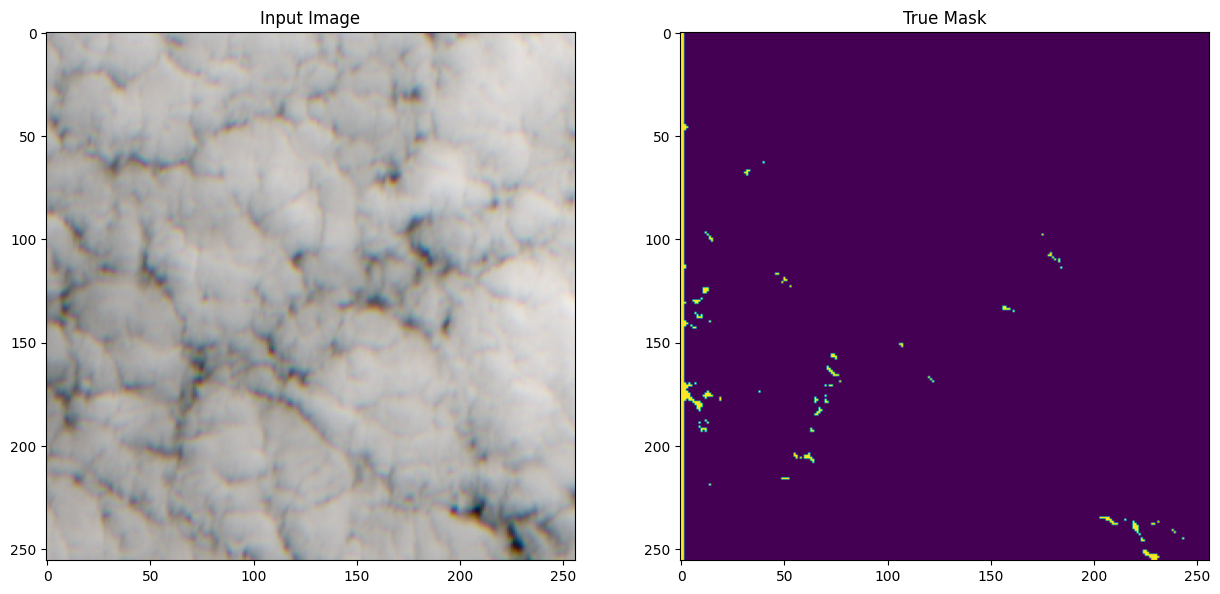

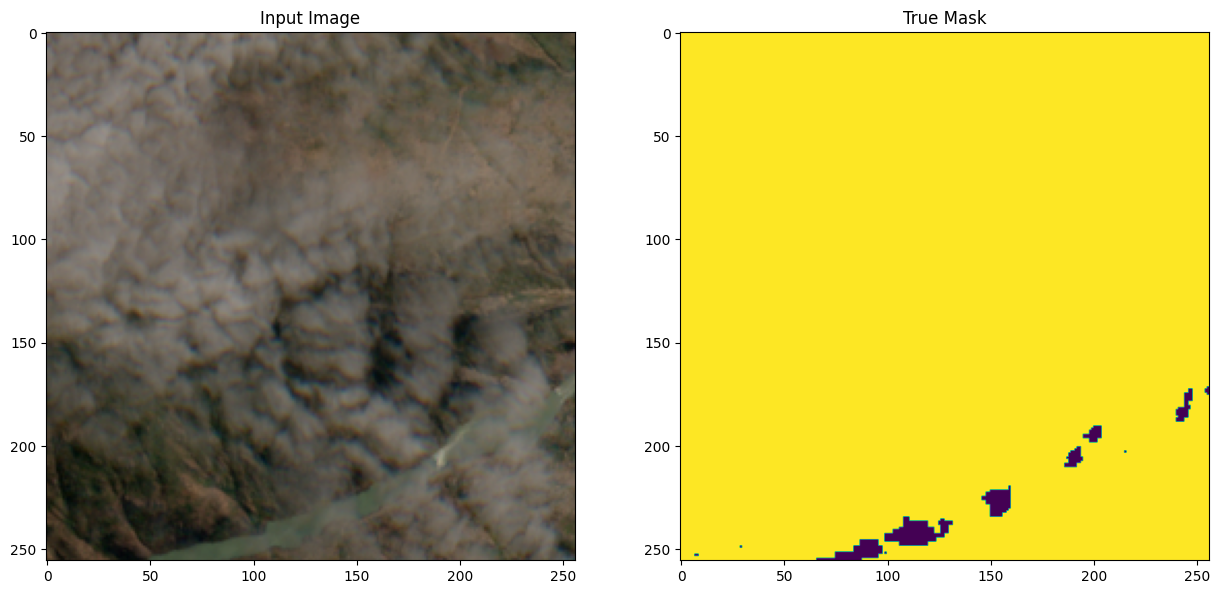

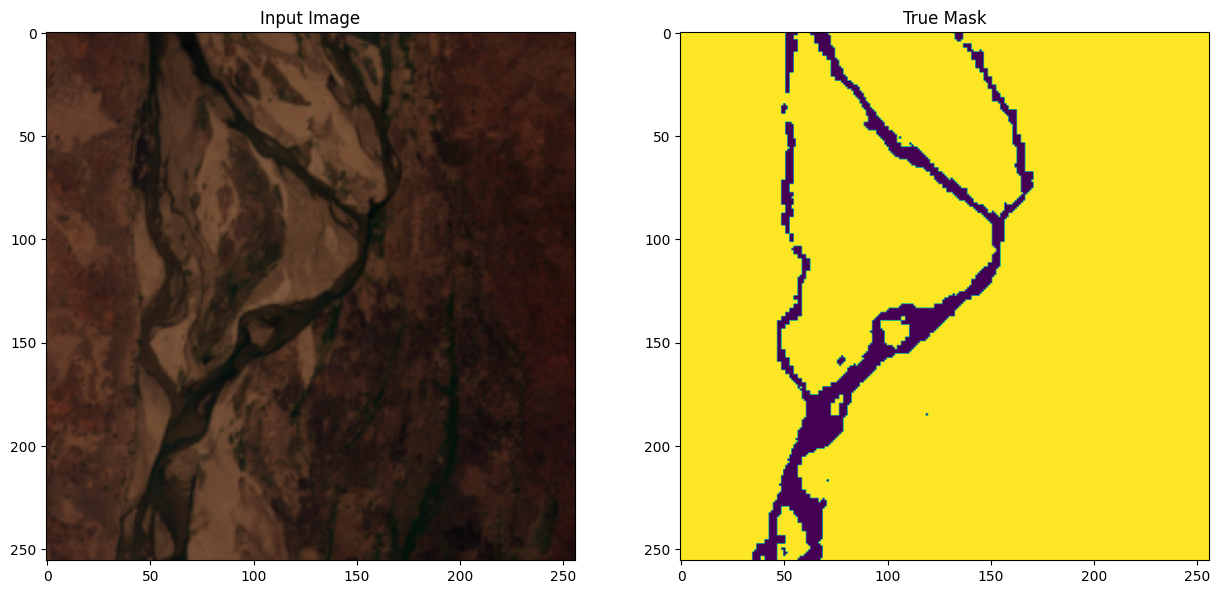

In [12]:
train_batch_img = train_generator.getitem_as_img(10)

display(train_batch_img[0][:3], train_batch_img[1][:3])

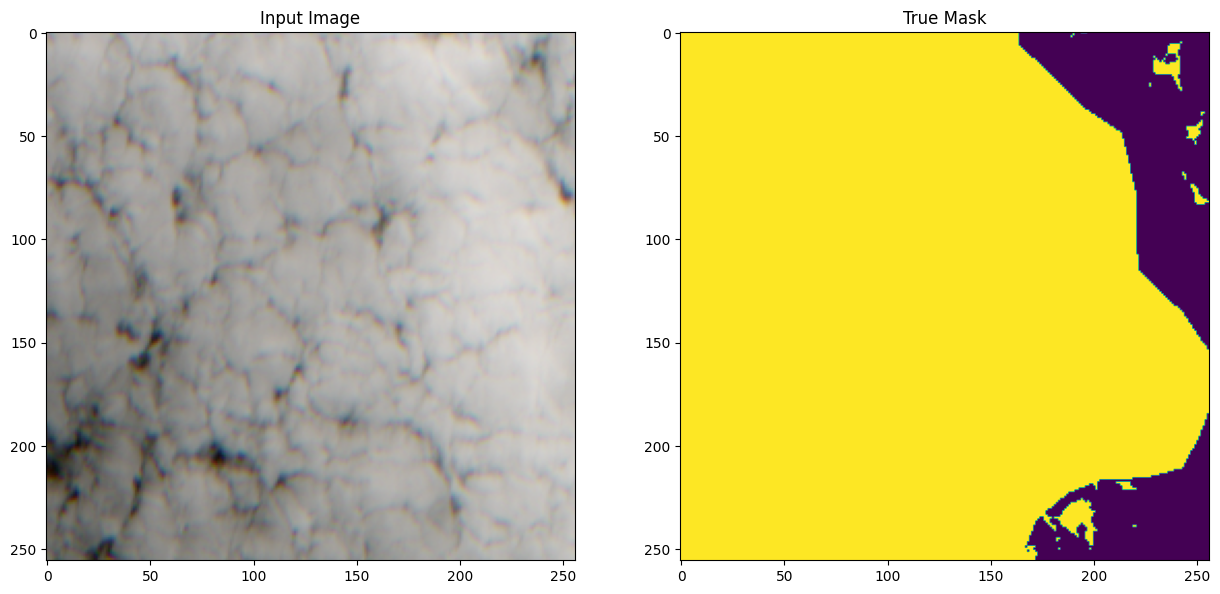

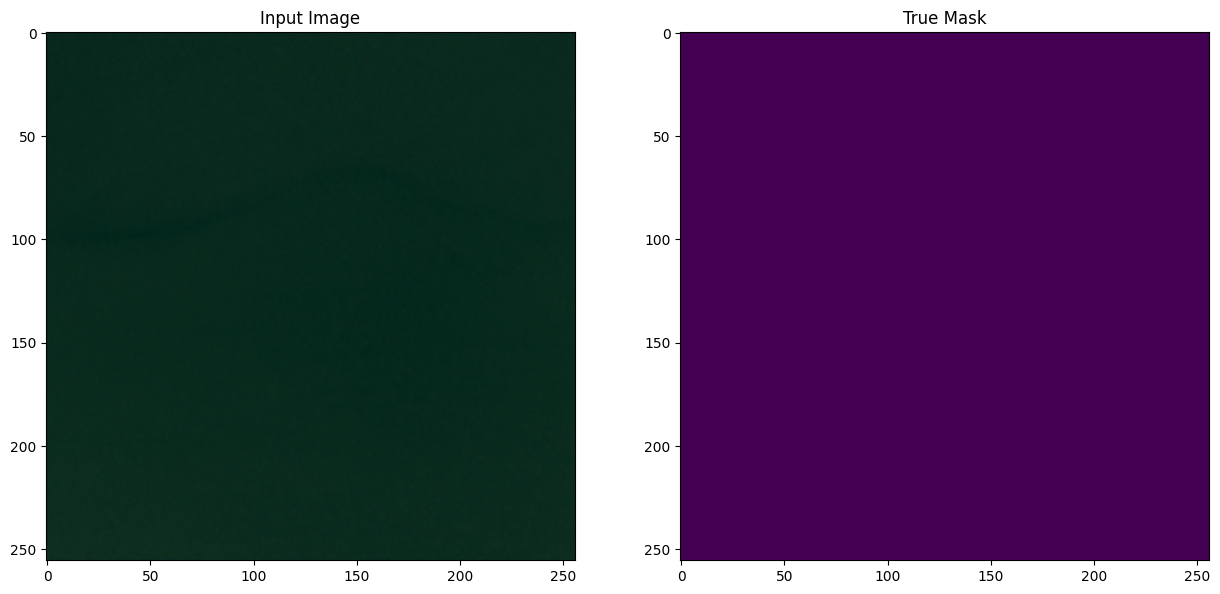

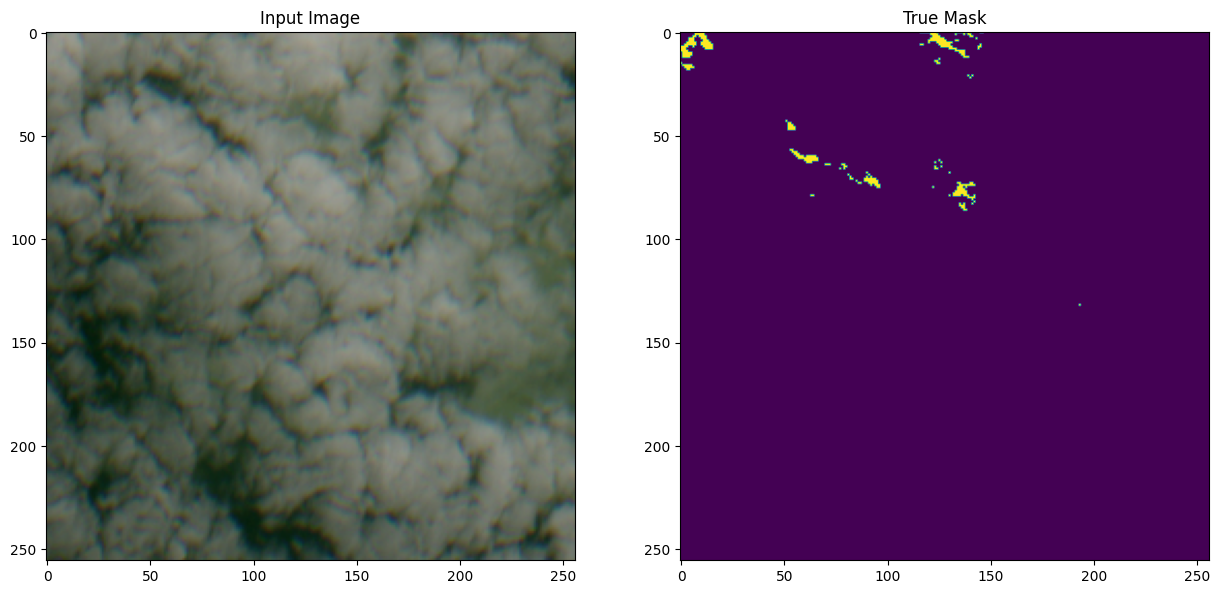

In [13]:
val_batch_img = val_generator.getitem_as_img(2)

display(val_batch_img[0][:3], val_batch_img[1][:3])

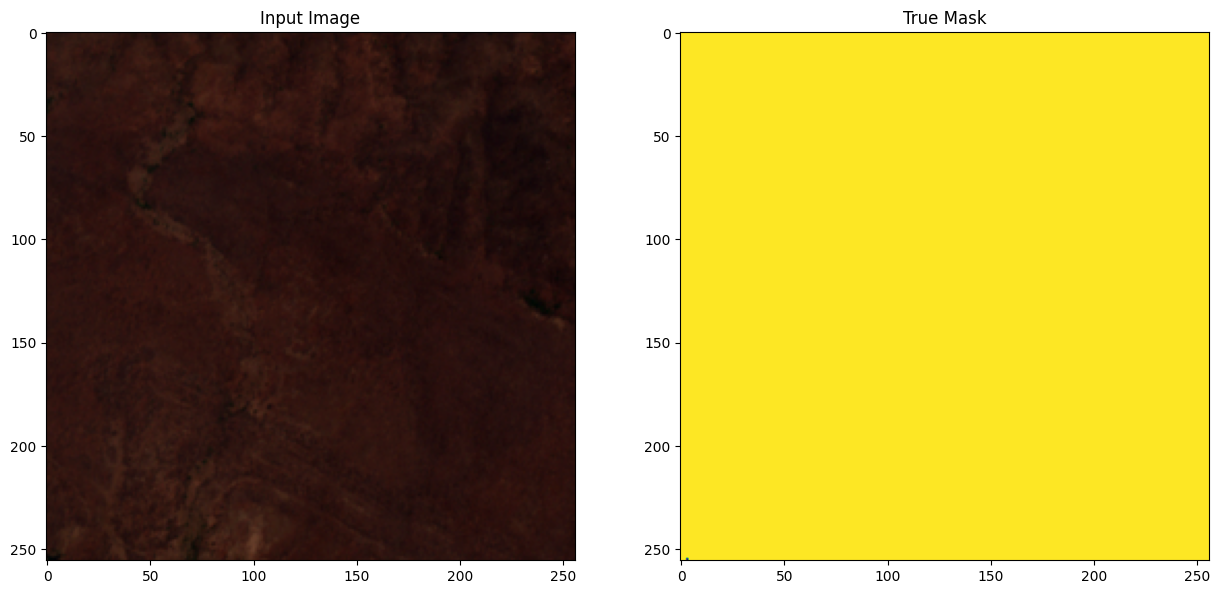

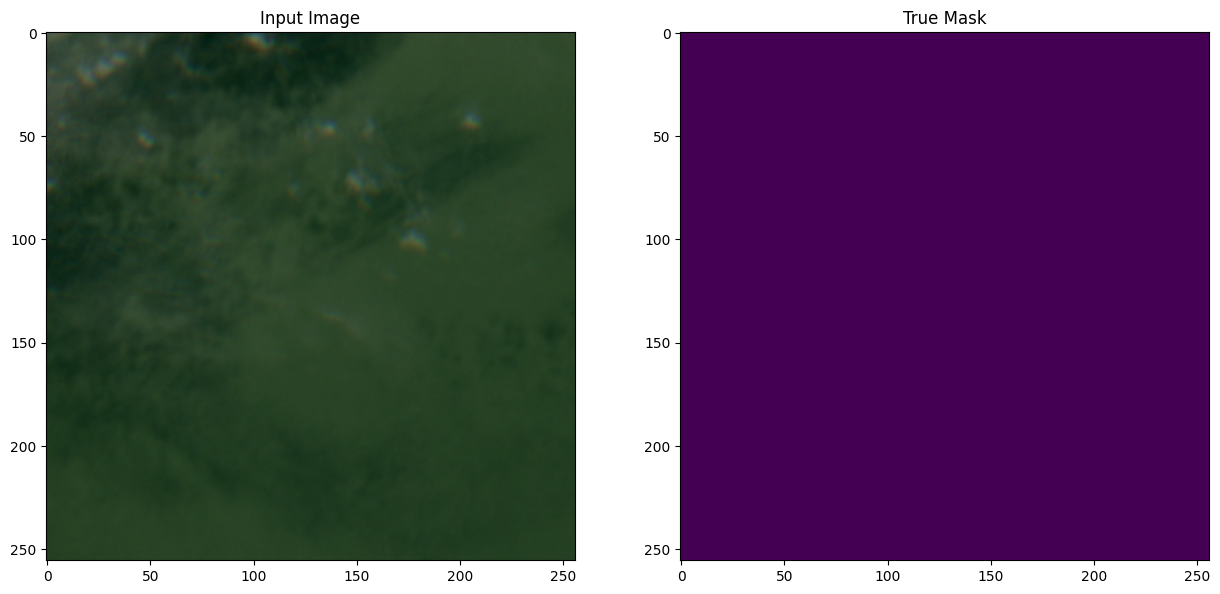

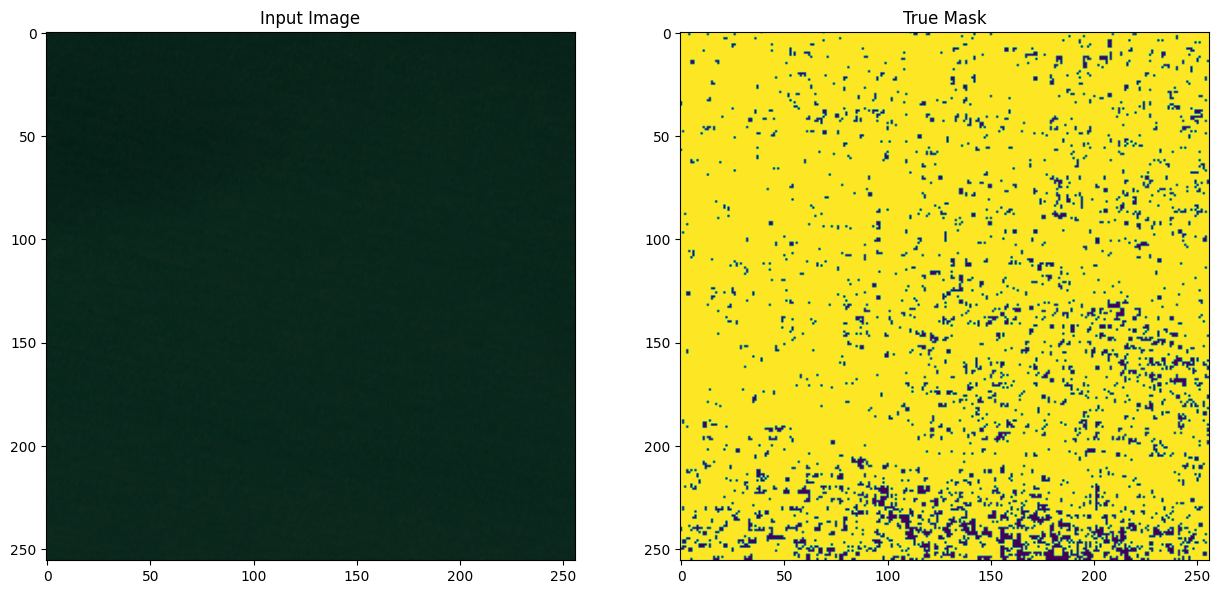

In [14]:
test_batch_img = test_generator.getitem_as_img(4)

display(test_batch_img[0][:3], test_batch_img[1][:3])

### 3. Model training

In [ ]:
!nvidia-smi

Tue Apr  4 22:39:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    49W / 400W |    697MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tile_size = 256
step_size = 256
experiment = 'experiment_4'
count = 0

print(f'Started at: {datetime.now()}')

for i in range(10):

  # compiling model
  model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
  model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])
  model.summary()

  # model training
  early_stop = EarlyStopping(monitor='accuracy', patience=5) 
  model_history = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stop])

  # Save model
  model_name = f'{tile_size}_{step_size}_run_{count}'
  model.save(f'../models/{experiment}/model_{model_name}.h5')
  print('saving model completed')

  # Save model history
  with open(f'../models/{experiment}/history_{model_name}.pkl', 'wb') as file_pi:
      pickle.dump(model_history.history, file_pi)
  print('saving history completed')

print(f'Finished at: {datetime.now()}')

Started at: 2023-04-04 22:39:22.930435
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2944        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                      

NameError: ignored

### 4. Make predictions

In [8]:
from datetime import datetime
def predictions_in_chunks(model, generator, num_tiles):
  num_batches = generator.__len__()
  pred_mmap = np.memmap('../models/experiment_3/predictions/pred_0.npy', mode="w+", shape=(num_tiles, 256, 256, 3), dtype=np.float32)
  
  for batch_idx in range (num_batches):
    print(f'batch {batch_idx}')
    batch_x, _ = generator.__getitem__(batch_idx) # _ is mask
    print(batch_x.shape)
    batch_preds = model.predict(batch_x)
    print(batch_preds.shape)
    
    start = batch_idx * batch_size
    end = start + batch_size
    print(f'start: {start} end: {end}')
    pred_mmap[start:end] = batch_preds
    print(f'end batch {batch_idx}: {datetime.now()}\n')


In [10]:
from datetime import datetime
from tensorflow.keras.models import load_model

print(f'start: {datetime.now()}')
path = '../models/experiment_3/model_256_256_run_0.h5'

model = load_model(path)

predictions_in_chunks(model, test_generator, test_val_tiles)

print(f'end: {datetime.now()}')

# check if gpu is needed for predictions

# calculate metrics

# how is generator dealing with rest?

start: 2023-04-22 19:21:35.400313
batch 0
(32, 256, 256, 5)
1/1 [==============================] - 0s 212ms/step
(32, 256, 256, 3)
start: 0 end: 32
end batch 0: 2023-04-22 19:21:37.555298

batch 1
(32, 256, 256, 5)
1/1 [==============================] - 0s 65ms/step
(32, 256, 256, 3)
start: 32 end: 64
end batch 1: 2023-04-22 19:21:38.288933

batch 2
(32, 256, 256, 5)
1/1 [==============================] - 0s 70ms/step
(32, 256, 256, 3)
start: 64 end: 96
end batch 2: 2023-04-22 19:21:39.251515

batch 3
(32, 256, 256, 5)
1/1 [==============================] - 0s 60ms/step
(32, 256, 256, 3)
start: 96 end: 128
end batch 3: 2023-04-22 19:21:40.106953

batch 4
(32, 256, 256, 5)
1/1 [==============================] - 0s 83ms/step
(32, 256, 256, 3)
start: 128 end: 160
end batch 4: 2023-04-22 19:21:40.945093

batch 5
(32, 256, 256, 5)
1/1 [==============================] - 0s 83ms/step
(32, 256, 256, 3)
start: 160 end: 192
end batch 5: 2023-04-22 19:21:42.086630

batch 6
(32, 256, 256, 5)
1/1 [

predictions without GPU take ~ 1 min, 10 s for 32 tiles, with standard GPU and RAM it takes ~ 1 s

In [ ]:
batch_x, _ = generator.__getitem__(batch_idx)

In [26]:
print(test_generator.__len__())

70


### sync


In [14]:
from tensorflow.keras.utils import to_categorical
from datetime import datetime

class ConfusionMatrix:

  __slots__ = [
      "true_positives",
      "false_positives",
      "true_negatives",
      "false_negatives"
  ]

  def __init__(self, tp=0, fp=0, tn=0, fn=0):
    self.true_positives = tp
    self.false_positives = fp
    self.true_negatives = tn
    self.false_negatives = fn
  
  def add_chunk(self, conf_matrix):
    self.true_positives += conf_matrix.true_positives
    self.false_positives += conf_matrix.false_positives
    self.true_negatives += conf_matrix.true_negatives
    self.false_negatives += conf_matrix.false_negatives



def get_confusion_matrix(y_true, y_pred, label):
    # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
    label_map_true = np.argmax(y_true, axis=-1)
    label_map_pred = np.argmax(y_pred, axis=-1)
    # convert 2D array into 1D array
    flatten_true = np.reshape(label_map_true, (-1,))
    flatten_pred = np.reshape(label_map_pred, (-1,))

    tp_mask = (flatten_true == flatten_pred) & (flatten_true == label)
    true_positives = np.count_nonzero(tp_mask)

    fn_mask = (flatten_true == label) & (flatten_pred != label)
    false_negatives = np.count_nonzero(fn_mask)

    fp_mask = (flatten_true != label) & (flatten_pred == label)
    false_positives = np.count_nonzero(fp_mask)

    tn_mask = (flatten_true != label) & (flatten_pred != label)
    true_negatives = np.count_nonzero(tn_mask)

    return ConfusionMatrix(tp=true_positives, fp=false_positives, tn=true_negatives, fn=false_negatives)


def get_intersections_unions(y_true: np.ndarray, y_pred: np.ndarray):
    intersections = []
    unions = []
    for label in range(3):
        y_true_f = keras.backend.flatten(y_true[..., label])
        y_pred_f = keras.backend.flatten(y_pred[..., label])
        intersection = keras.backend.sum(y_true_f * y_pred_f)
        union = (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection)

        intersections.append(intersection)
        unions.append(union)

    return intersections, unions

class ChunkJaccardMatrix:
    """
    This class calculates and the confusion matrix and the jaccard index for each label in chunks.
    """

    __slots__ = [
        "conf_matrix_land",
        "conf_matrix_valid",
        "conf_matrix_invalid",
        "intersections",
        "unions",
        "current_chunk_index",
        "num_chunks",
        "chunk_size",
        "y_true",
        "y_pred",
        "mean_jaccard",
        "jaccard_invalid",
        "jaccard_valid",
        "jaccard_land",

    ]

    def __init__(self, y_true: np.memmap, y_pred: np.memmap, chunk_size=1000):
        self.conf_matrix_land = ConfusionMatrix()
        self.conf_matrix_valid = ConfusionMatrix()
        self.conf_matrix_invalid = ConfusionMatrix()

        self.intersections = [0, 0, 0]
        self.unions = [0, 0, 0]

        self.current_chunk_index = 0
        self.num_chunks = y_true.shape[0] // chunk_size
        self.chunk_size = chunk_size
        self.y_true = y_true
        self.y_pred = y_pred

        self.mean_jaccard = 0
        self.jaccard_invalid = 0
        self.jaccard_valid = 0
        self.jaccard_land = 0

        self.calculate_jaccard_matrix()

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_chunk_index >= self.num_chunks:
            raise StopIteration
        print(datetime.now())
        start = self.current_chunk_index * self.chunk_size
        end = start + self.chunk_size
        if self.current_chunk_index == self.num_chunks:
            end = self.tiles

        pred_chunk = np.argmax(self.y_pred[start:end], axis=-1)

        pred_chunk = to_categorical(pred_chunk, num_classes=3)

        y_true_chunk = np.copy(self.y_true[start:end])
        y_true_chunk = to_categorical(y_true_chunk, num_classes=3)
       
        chunk_intersections, chunk_unions = get_intersections_unions(y_true_chunk, pred_chunk)

        for label in range(3):

            self.intersections[label] += chunk_intersections[label]
            self.unions[label] += chunk_unions[label]

        self.conf_matrix_invalid.add_chunk(get_confusion_matrix(y_true_chunk, pred_chunk, 0))
        self.conf_matrix_valid.add_chunk(get_confusion_matrix(y_true_chunk, pred_chunk, 1))
        self.conf_matrix_land.add_chunk(get_confusion_matrix(y_true_chunk, pred_chunk, 2))

        self.current_chunk_index += 1

    def calculate_jaccard_matrix(self):
        for num_chunks in self:
            pass
        self.calculate_jaccards()

    def calculate_jaccards(self):
        jaccards = []
        total_intersection = 0
        total_union = 0
        for label in range(3):
            jaccards.append((self.intersections[label] + 1.0) / (self.unions[label] + 1.0))
            total_intersection += self.intersections[label]
            total_union += self.unions[label]
            
        self.jaccard_invalid = jaccards[0]
        self.jaccard_valid = jaccards[1]
        self.jaccard_land = jaccards[2]
        self.mean_jaccard = (total_intersection + 1.0) / (total_union + 1.0)

In [12]:
class EvaluationMetricsTotal:
    """
    This class calculates and summarizes evaluation metrics based on the predicted and true labels.
    """

    __slots__ = [
        "chunk_jaccard_matrix",
        "mean_jaccard",
        "jaccard_invalid",
        "jaccard_valid",
        "jaccard_land",

        "conf_matrix_invalid",
        "conf_matrix_valid",
        "conf_matrix_land",

        "precision_invalid",
        "precision_valid",
        "precision_land",

        "sensitivity_recall_invalid",
        "sensitivity_recall_valid",
        "sensitivity_recall_land",

        "specificy_invalid",
        "specificy_valid",
        "specificy_land",

        "f1_invalid",
        "f1_valid",
        "f1_land",
    ]

    def __init__(self, y_true: np.memmap, y_pred: np.memmap):

        self.chunk_jaccard_matrix = ChunkJaccardMatrix(y_true, y_pred)

        self.mean_jaccard = self.chunk_jaccard_matrix.mean_jaccard
        self.jaccard_invalid = self.chunk_jaccard_matrix.jaccard_invalid
        self.jaccard_valid = self.chunk_jaccard_matrix.jaccard_valid
        self.jaccard_land = self.chunk_jaccard_matrix.jaccard_land

        self.conf_matrix_invalid = self.chunk_jaccard_matrix.conf_matrix_invalid
        self.conf_matrix_valid = self.chunk_jaccard_matrix.conf_matrix_valid
        self.conf_matrix_land = self.chunk_jaccard_matrix.conf_matrix_land

        self.precision_land = self.precision(self.conf_matrix_land)
        self.sensitivity_recall_land = self.sensitivity_recall(self.conf_matrix_land)
        self.specificy_land = self.specificy(self.conf_matrix_land)

        self.precision_valid = self.precision(self.conf_matrix_valid)
        self.sensitivity_recall_valid = self.sensitivity_recall(self.conf_matrix_valid)
        self.specificy_valid = self.specificy(self.conf_matrix_valid)

        self.precision_invalid = self.precision(self.conf_matrix_invalid)
        self.sensitivity_recall_invalid = self.sensitivity_recall(
            self.conf_matrix_invalid
        )
        self.specificy_invalid = self.specificy(self.conf_matrix_invalid)

        self.f1_land = self.f1_scores(self.conf_matrix_land)
        self.f1_invalid = self.f1_scores(self.conf_matrix_invalid)
        self.f1_valid = self.f1_scores(self.conf_matrix_valid)

    def precision(self, conf_matrix):
        if conf_matrix.true_positives == 0 or conf_matrix.false_positives == 0:
            print(
                f"Precision 0 values: {(conf_matrix.true_positives)} {conf_matrix.false_positives}"
            )
            return 0
        return conf_matrix.true_positives / (
            conf_matrix.true_positives + conf_matrix.false_positives
        )

    def sensitivity_recall(self, conf_matrix):
        if conf_matrix.true_positives == 0 or conf_matrix.false_negatives == 0:
            print(
                f"Sensitivity 0 values: {(conf_matrix.true_positives)} {conf_matrix.false_negatives}"
            )
            return 0
        return conf_matrix.true_positives / (
            conf_matrix.true_positives + conf_matrix.false_negatives
        )

    def negative_predictive(self, conf_matrix):
        if conf_matrix.true_negatives == 0 or conf_matrix.false_negatives == 0:
            print(
                f"negative_predictive Error 0 values: {conf_matrix.true_negatives} {conf_matrix.false_negatives}"
            )
            return 0
        return conf_matrix.true_negatives / (
            conf_matrix.true_negatives + conf_matrix.false_negatives
        )

    def specificy(self, conf_matrix):
        if conf_matrix.true_negatives == 0 or conf_matrix.false_positives == 0:
            print(
                f"specificy 0 values: {conf_matrix.true_negatives} {(conf_matrix.false_positives)}"
            )
            return 0
        return conf_matrix.true_negatives / (
            conf_matrix.true_negatives + conf_matrix.false_positives
        )

    def f1_scores(self, conf_matrix):
        prec = self.precision(conf_matrix)
        recall = self.sensitivity_recall(conf_matrix)
        if prec + recall == 0:
            print("f1 score 0")
            return 0
        return 2 * prec * recall / (prec + recall)

    def print_metrics(self):
        print(f"mean jaccard index: {self.mean_jaccard}")
        print(f"invalid jaccard index: {self.jaccard_invalid}")
        print(f"valid jaccard index: {self.jaccard_valid}")
        print(f"land jaccard index: {self.jaccard_land} \n")


        print(f"precision_land: {self.precision_land}")
        print(f"precision_valid: {self.precision_valid}")
        print(f"precision_invalid: {self.precision_invalid} \n")

        print(f"recall_invalid_land: {self.sensitivity_recall_land}")
        print(f"recall_invalid_land: {self.sensitivity_recall_valid}")
        print(f"recall_invalid_land: {self.sensitivity_recall_invalid} \n")

        print(f"specificy_invalid_land: {self.specificy_land}")
        print(f"specificy_invalid_valid: {self.specificy_valid}")
        print(f"specificy_invalid_invalid: {self.specificy_invalid} \n")

        print(f"f1_land: {self.f1_land}")
        print(f"f1_invalid: {self.f1_invalid}")
        print(f"f1_valid: {self.f1_valid}")


### asdf

In [15]:
pred_mmap = np.memmap('../models/experiment_3/predictions/pred_0.npy', mode="r", shape=(test_val_tiles, 256, 256, 3), dtype=np.float32)

print(f'start: {datetime.now()}')
metrics = EvaluationMetricsTotal(test_split_y, pred_mmap)
print(f'end: {datetime.now()}')

start: 2023-04-22 22:08:00.903822
2023-04-22 22:08:00.907163
2023-04-22 22:08:13.440789
end: 2023-04-22 22:08:25.542287


In [16]:
pred_mmap = np.memmap('../models/experiment_3/predictions/pred_0.npy', mode="r", shape=(test_val_tiles, 256, 256, 3), dtype=np.float32)

print(f'start: {datetime.now()}')
metrics = EvaluationMetricsTotal(val_split_y, pred_mmap)
print(f'end: {datetime.now()}')

start: 2023-04-22 22:09:53.201923
2023-04-22 22:09:53.203259
2023-04-22 22:10:08.888675
end: 2023-04-22 22:10:26.975738


In [17]:
metrics.print_metrics()

mean jaccard index: 0.23480547964572906
invalid jaccard index: 0.1817118376493454
valid jaccard index: 0.2088954895734787
land jaccard index: 0.2853134870529175 

precision_land: 0.4499934917324862
precision_valid: 0.3383179506591559
precision_invalid: 0.30859655933900565 

recall_invalid_land: 0.4380849326684225
recall_invalid_land: 0.3531967246365397
recall_invalid_land: 0.30649066944812414 

specificy_invalid_land: 0.5594772454486857
specificy_invalid_valid: 0.6913599802230903
specificy_invalid_invalid: 0.7833729173670905 

f1_land: 0.44395936915107614
f1_invalid: 0.3075400093990007
f1_valid: 0.3455972702458253


evaluation metrics calculation takes ~ 15 s per 1000 tiles => no GPU needed

In [89]:
metrics.print_metrics()

mean jaccard index: 0.9029309153556824
invalid jaccard index: 0.7993141412734985
valid jaccard index: 0.8721622824668884
land jaccard index: 0.9832777976989746 

precision_land: 0.9945142047091683
precision_valid: 0.9243189126342608
precision_invalid: 0.893353272610815 

recall_invalid_land: 0.9886399685440612
recall_invalid_land: 0.9392335054046409
recall_invalid_land: 0.883630630478266 

specificy_invalid_land: 0.9954775419137751
specificy_invalid_valid: 0.9639270445015109
specificy_invalid_invalid: 0.9689593258961118 

f1_land: 0.9915683866851305
f1_invalid: 0.8884653531690928
f1_valid: 0.9317165259444397


In [58]:
from tensorflow.keras.utils import to_categorical
start = 0
end = 1

pred_mmap = np.memmap('../models/experiment_3/predictions/pred_0.npy', mode="r", shape=(test_val_tiles, 256, 256, 3), dtype=np.float32)

pred_chunk = pred_mmap[start:end]
print(np.max(pred_chunk))
print(np.min(pred_chunk))
pred_chunk = np.argmax(pred_chunk, axis=-1)
print(np.max(pred_chunk))
print(np.min(pred_chunk))
pred_chunk = to_categorical(pred_chunk, num_classes=3)
print(np.max(pred_chunk))
print(np.min(pred_chunk))

#print(pred_chunk.shape)
#print(pred_chunk[0][0][0:5])

pred_chunk = keras.backend.flatten(pred_chunk[..., 2])
print(np.max(pred_chunk))
print(np.min(pred_chunk))
#print(y_true_f.shape)
#print(pred_chunk[..., 1][0][0][0:5])

#y_true_chunk = np.copy(test_split_y[start:end])
#print(y_true_chunk.shape)

1.0
2.8803715e-13
2
0
1.0
0.0
1.0
0.0


In [60]:
t = (1,2)
t[0] += 2
print(t)

TypeError: ignored